In [18]:
import librosa
import librosa.display
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import IPython.display

In [19]:
audio, _ = librosa.load("./data/sentence.wav", sr=8000)

In [47]:
audio, _ = librosa.load("./data/ILoveKanye.mp3", sr=8000)

/Users/vaclav/prog/venv2/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [48]:
def play(audio, sr=8000):
    IPython.display.display(IPython.display.Audio(audio, rate=sr))

def specplot(audio, n_fft=512):
    S = librosa.stft(audio, n_fft=n_fft)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(S_db, y_axis="linear", sr=8000, n_fft=n_fft)

In [49]:
audio2 = scipy.signal.lfilter(np.array([1.0, -0.9]), 1, audio)

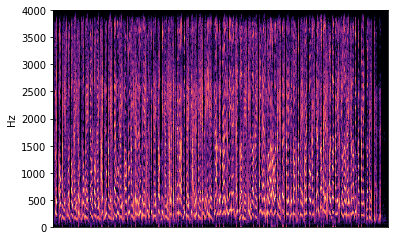

In [50]:
specplot(audio)

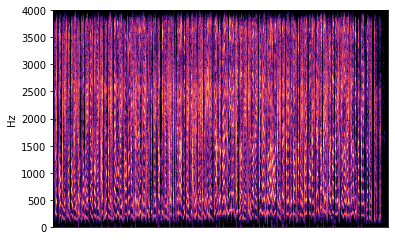

In [51]:
specplot(audio2)

In [55]:
def lpcfit(x, p=12, h=128, w=None, ov=1):
    if w is None:
        w = 2 * h

    npts = len(x)
    nhops = npts // h

    # x = librosa.util.pad_center(x, size=np.ceil(len(x) / h) * h)
    # assert len(x) % h == 0
    x = np.concatenate([np.zeros((w - h) // 2), x, np.zeros((w - h) // 2)])

    a = np.zeros((nhops, p + 1))
    g = np.zeros(nhops)
    e = np.zeros((nhops - 1) * h + w)

    #     if ov == 0
    #   e = zeros(1, npts);
    # else
    #   e = zeros(1, (nhops-1)*h+w);
    # end

    x = scipy.signal.lfilter(np.array([1.0, -0.9]), 1, x)

    for hop in range(nhops):
        xx = x[hop * h : hop * h + w]
        wxx = xx * scipy.signal.get_window("hanning", w)

        rxx = scipy.signal.correlate(wxx, wxx)
        rxx = rxx[w - 1 : w + p]

        try:
            an = scipy.linalg.solve_toeplitz(rxx[:p], rxx[1 : p + 1])
        except scipy.linalg.LinAlgError:  # "Singular principal minor"
            continue
        # print(an.shape)

        aa = np.concatenate([[1], -an])
        rs = scipy.signal.lfilter(aa, 1, wxx)

        G = np.sqrt(np.mean(rs**2))
        a[hop] = aa
        g[hop] = G

        e[hop * h : hop * h + w] += rs / G
        # e((hop - 1)*h + [1:w]) =  e((hop - 1)*h + [1:w]) + rs/G;
        # break

    e = e[(w - h) // 2 :]

    return a, g, e


a, g, e = lpcfit(audio, p=8)


In [64]:
def lpca2frq(a, g):
    nhops, p = a.shape

    f = np.zeros((nhops, (p - 1) // 2))
    m = np.zeros((nhops, (p - 1) // 2))

    for hop in range(nhops):
        aa = a[hop]
        G = g[hop]
        an = aa[1:p]
        rts = np.roots(np.concatenate([[1], an]))
        frqs = np.angle(rts)
        mags = G / (1 - np.abs(rts))
        
        ix = np.argsort(frqs)
        keep = frqs[ix] > 0
        ix = ix[keep]
        
#         assert len(ix) <= f.shape[1], f"{frqs=}"

        f[hop,:len(ix)] = frqs[ix][:f.shape[1]]
        m[hop,:len(ix)] = mags[ix][:f.shape[1]]
#         print(an)

        # if hop == 3:
        #     break

    return f, m

f, m = lpca2frq(a, g)
f = f*8000/(2*np.pi)

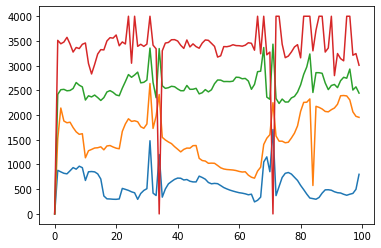

In [68]:
plt.plot(f[:100])
# specplot(audio)

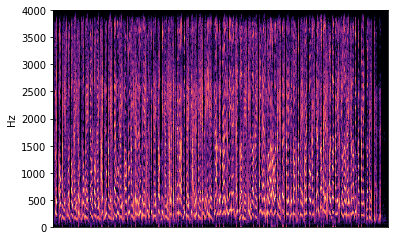

In [69]:
specplot(audio)

In [70]:
play(audio)

In [71]:
f.shape

(2803, 4)

In [78]:
def synthtrax(F, M, SR, SUBF=128, DUR=0):
    cols, rows = F.shape

    opsamps = round(DUR * SR)
    if DUR == 0:
        opsamps = 1 + (cols - 1) * SUBF

    X = np.zeros(opsamps)

    for row in range(rows):
        mm = M[:, row]
        ff = F[:, row]

        mm = np.nan_to_num(mm)
        ff = np.nan_to_num(ff)
        # assert np.sum(mm == 0) == 0

        nzcols = len(mm)

        def resample(x, factor):
            output_size = (len(mm) - 1) * factor + 1
            return np.interp(
                np.arange(output_size),
                np.arange(len(x)) * factor,
                x
            )

        ff = resample(ff, factor=SUBF)
        mm = resample(mm, factor=SUBF)
        
        pp = np.cumsum(2*np.pi*ff/SR)

        xx = mm * np.cos(pp)
#         xx = mm * scipy.signal.sawtooth(pp)

        X += xx
#         break
    
    return X


X = synthtrax(f, m, 8000)


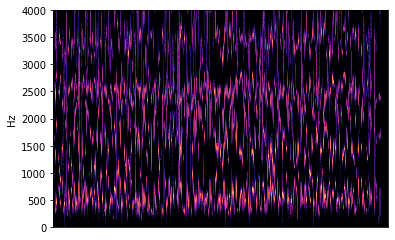

In [79]:
specplot(X)

In [80]:
play(X)